In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import skvideo.io
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import ipywidgets as widgets
# from IPython.html.widgets import *
from ipywidgets import interact
import pickle
import h5py 
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF


%matplotlib inline

Using TensorFlow backend.


In [2]:
# constants
data_dir = 'data'
train_data = os.path.join(data_dir, 'train.mp4') #'drive.mp4' 'train.mp4'
test_data = os.path.join(data_dir, 'test.mp4')
clean_data = 'clean_data'
clean_train = os.path.join(clean_data, 'train_imgs') #train2_imgs train_imgs
clean_test = os.path.join(clean_data, 'test_imgs')
assets = 'assets'

train_frames = 8616 #20400 #8616
test_frames = 10798

seed = 0

# hyperparameters
batch_size = 50
n_epochs = 25 #100 #90 
steps_per_epoch = 400

# run specific constants
model_name = 'nvidia' #nvidia2
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          n_epochs,
                                                                          steps_per_epoch)

assets_path = os.path.join(assets, 'model_assets' , run_name)
weights_loc = os.path.join(assets_path,'weights.h5')
history_loc=  os.path.join(assets_path,'history.p')
tensorboard_loc = os.path.join(assets_path, run_name)

In [3]:
run_name

'model=nvidia-batch_size=50-num_epoch=25-steps_per_epoch=400'

In [4]:
processed_train = pd.read_csv(os.path.join(clean_data, 'train_processed.csv')) #train2_meta
print('shape: ', processed_train.shape)

shape:  (20400, 3)


In [5]:
def chunks(l, n):
    """ Yield successive n-sized chunks from l.
    """
    for i in range(0, len(l), n):
        yield l[i:i+n]

def new_split(dframe):
    data = dframe.to_numpy()
    data = np.asarray(list(chunks(data, 2)))
    for _ in range(5): np.random.shuffle(data)
#     train_indices = np.arange(len(data))
#     print('train_indices:', train_indices.shape[0])
#     valid_indices = np.random.choice(len(data), int(0.2*len(data)))
#     valid_data = data[valid_indices]
#     train_data = np.delete(data, valid_indices, 0)
    train_data = data[:int(0.8*len(data))]
    valid_data = data[int(0.8*len(data)):]
    return train_data.reshape(-1,3), valid_data.reshape(-1,3)

In [6]:
train_data, valid_data = new_split(processed_train)

In [7]:
def brighten(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [8]:
def opticalFlowDense(current_img, next_img):
    """
    input: current_img, next_img (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of next_img
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    current_gray = cv2.cvtColor(current_img, cv2.COLOR_RGB2GRAY)
    next_gray = cv2.cvtColor(next_img, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(next_img, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(current_gray, next_gray,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = angle * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(magnitude,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

In [9]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    #image_cropped = image[100:440, :-90] # -> (380, 550, 3) #v2 for data
    image_cropped = image[25:375, :] #v1 for data
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

original image shape: (480, 640, 3)


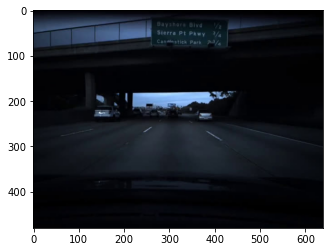

post prosessed image: (66, 220, 3)


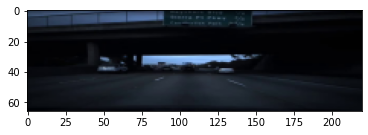

In [10]:
img=mpimg.imread(processed_train['image_path'][10])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post prosessed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [11]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = brighten(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

In [12]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            index = np.random.randint(1, len(data) - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
#             curr_row = data.iloc[[index]].reset_index()
#             prev_row = data.iloc[[index - 1]].reset_index()
#             next_row = data.iloc[[index + 1]].reset_index()
            curr_row = data[index]
            prev_row = data[index-1]
            next_row = data[index+1]
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            curr_time = curr_row[1]
            prev_time = prev_row[1]
            next_time = next_row[1]
#             curr_time = curr_row['image_index'].values[0]
#             prev_time = prev_row['image_index'].values[0]
#             next_time = next_row['image_index'].values[0]
            
            if abs(curr_time - prev_time) == 1 and curr_time > prev_time:
                row1 = prev_row
                row2 = curr_row
                
            elif abs(next_time - curr_time) == 1 and next_time > curr_time:
                row1 = curr_row
                row2 = next_row
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(row1[0], row1[2], bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2[0], row2[2], bright_factor)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

In [13]:
def generate_validation_data(data):
    while True:
        for index in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
#             row_now = data.iloc[[idx]].reset_index()
#             row_prev = data.iloc[[idx - 1]].reset_index()
#             row_next = data.iloc[[idx + 1]].reset_index()
            row_now = data[index]
            row_prev = data[index-1]
            row_next = data[index+1]
            
            # Find the 3 respective times to determine frame order (current -> next)
            
#             time_now = row_now['image_index'].values[0]
#             time_prev = row_prev['image_index'].values[0]
#             time_next = row_next['image_index'].values[0]
            time_now = row_now[1]
            time_prev = row_prev[1]
            time_next = row_next[1]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
                
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')        
            
            x1, y1 = preprocess_image_valid_from_path(row1[0], row1[2])
            x2, y2 = preprocess_image_valid_from_path(row2[0], row2[2])
            
            img_diff = opticalFlowDense(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            
            #print('img_diff', img_diff.shape, ' speed', speed)
            yield img_diff, speed

In [14]:
N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [15]:
if not os.path.exists(assets_path):
    os.makedirs(assets_path)

In [16]:
valid_generator = generate_validation_data(valid_data)
val_size = len(valid_data)

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(weights_loc, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)

tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                            write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, tensorboard, earlyStopping]

In [17]:
valid_generator

<generator object generate_validation_data at 0x12b4736d0>

In [18]:
model = nvidia_model()

In [19]:
train_size = len(train_data)
train_generator = generate_training_data(train_data, batch_size)
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = n_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

Epoch 1/25
400/400 [==============================] - 434s 1s/step - loss: 142.7326 - val_loss: 2.6271

Epoch 00001: val_loss improved from inf to 2.62710, saving model to assets/model_assets/model=nvidia-batch_size=50-num_epoch=25-steps_per_epoch=400/weights.h5
Epoch 2/25
400/400 [==============================] - 416s 1s/step - loss: 49.8089 - val_loss: 24.9860

Epoch 00002: val_loss did not improve from 2.62710
Epoch 00002: early stopping


In [20]:
# saving history
pickle.dump(history.history, open(history_loc, "wb"))

### Post Analysis

In [21]:
# model processing hyperparameters
batch_size = 16
n_epochs = 25 #100 #90 
steps_per_epoch = 400

# run specific constants
model_name = 'nvidia' #nvidia2
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          n_epochs,
                                                                          steps_per_epoch)

In [22]:
history = pickle.load(open(history_loc, "rb" ))
model.load_weights(weights_loc)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = adam, loss = 'mse')

In [23]:
val_score = model.evaluate_generator(valid_generator, steps=val_size)
print('val score:', val_score)

val score: 91.93055725097656


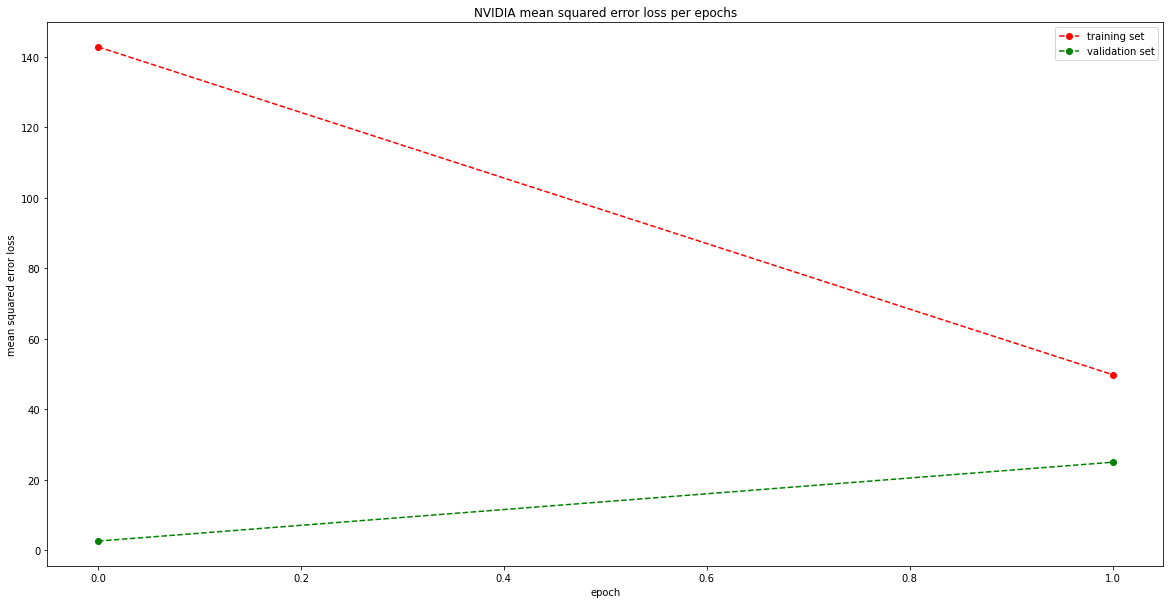

In [24]:
### plot the training and validation loss for each epoch
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history['loss'], 'ro--')
plt.plot(history['val_loss'], 'go--')
plt.title('NVIDIA mean squared error loss per epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()


In [25]:
def make_predictions(data):
    data = np.hstack((data, np.empty((data.shape[0], 2))))
    for index in tqdm(range(1, len(data)-1)):
#         row_now = data.iloc[[idx]].reset_index()
#         row_prev = data.iloc[[idx - 1]].reset_index()
#         row_next = data.iloc[[idx + 1]].reset_index()
        row_now = data[index]
        row_prev = data[index-1]
        row_next = data[index+1]
        
        time_now = row_now[1]
        time_prev = row_prev[1]
        time_next = row_next[1]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
        else:
            print('Error generating row')
        
        x1, y1 = preprocess_image_valid_from_path(row1[0], row1[2])
        x2, y2 = preprocess_image_valid_from_path(row2[0], row2[2])
        
        img_diff = opticalFlowDense(x1, x2)
        img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
        y = np.mean([y1, y2])

        prediction = model.predict(img_diff)
        error = abs(prediction-y2)
        
        
        #print(prediction, error, time_now)
        data[data[:,1]==time_now, 3] = prediction[0][0]
        data[data[:,1]==time_now, 4] = error[0][0]
    return data

In [26]:
valid_data = make_predictions(valid_data)

100%|██████████| 4078/4078 [00:55<00:00, 73.42it/s]


In [27]:
print(mean_squared_error(valid_data[1:-1, 2], 
                         valid_data[1:-1, 3]))

55.92742226521894


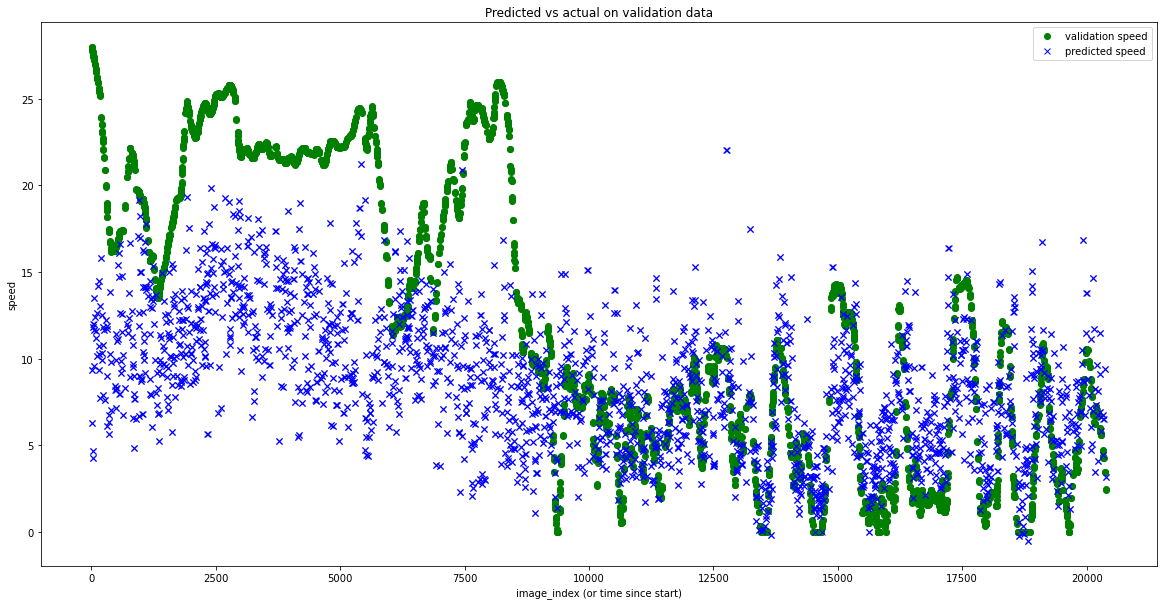

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
# plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
#          valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.plot(valid_data[:,1], valid_data[:,2], 'go')
# plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
#          valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(valid_data[:,1], valid_data[:,3], 'bx')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted vs actual on validation data')
plt.legend(['validation speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

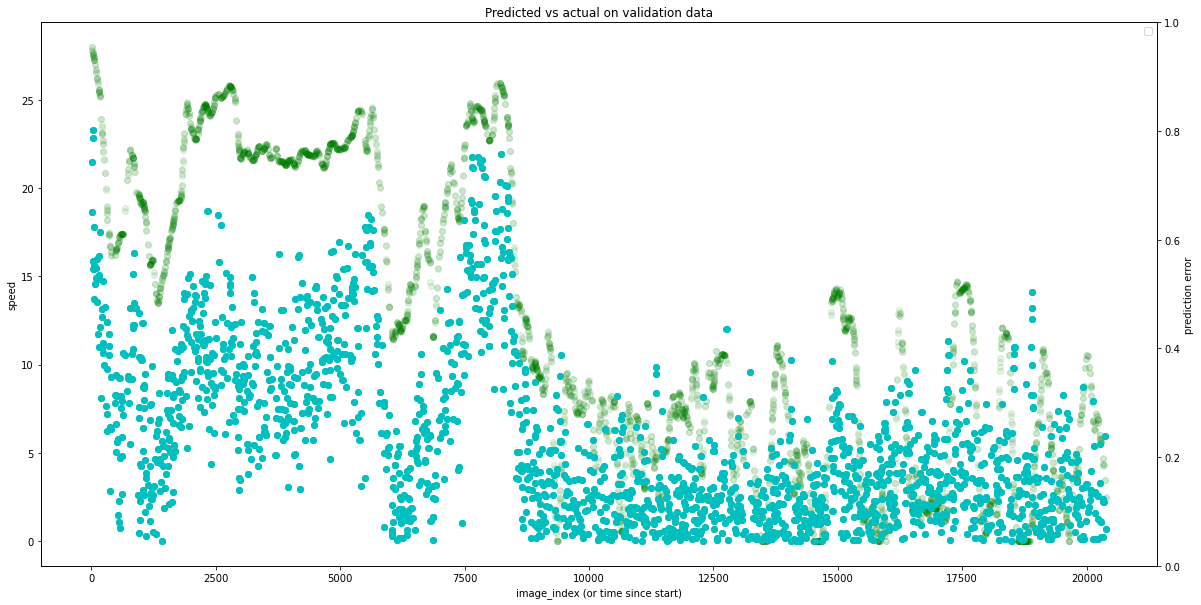

In [29]:
fig, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(valid_data.sort_values(['image_index'])[['image_index']], 
#          valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.1)
ax1.plot(valid_data[:,1], valid_data[:,2], 'go', alpha=0.1)
ax2 = ax1.twinx()
# ax2.plot(valid_data.sort_values(['image_index'])[['image_index']], 
#          valid_data.sort_values(['image_index'])[['error']], 'co')
ax1.plot(valid_data[:,1], valid_data[:,4], 'co')
ax1.set_xlabel('image_index (or time since start)')
ax1.set_ylabel('speed')
ax2.set_ylabel('prediction error')
plt.title('Predicted vs actual on validation data')
plt.legend(['prediction error'], loc='upper right')
plt.show()
plt.close()

In [30]:
def error_analysis(error_thresh):
    fig, ax = plt.subplots(figsize=(20,10))
#     ax.plot(valid_data.sort_values(['image_index'])[['image_index']], 
#              valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.4)
    
    a = valid_data[valid_data[:,4]>error_thresh]
    ax.plot(a[a[:,1].argsort()][:,1], 
            a[a[:,1].argsort()][:,3], 'go', alpha=0.4)

#     ax.plot(valid_data[valid_data['error']>error_thresh].sort_values(['image_index'])[['image_index']], 
#              valid_data[valid_data['error']>error_thresh].sort_values(['image_index'])[['speed']], 'rx')
    ax.plot(a[a[:,1].argsort()][:,1], 
            a[a[:,1].argsort()][:,3], 'rx')


    ax.set_xlabel('image_index (or time since start)')
    ax.set_ylabel('speed')
    plt.title('Error analysis on validation data')
    plt.legend(['Ground truth', 'Incorrect prediction'], loc='upper right')
    plt.show()

interact(error_analysis, error_thresh=(0,5, 0.1))

interactive(children=(FloatSlider(value=2.0, description='error_thresh', max=5.0), Output()), _dom_classes=('w…

<function __main__.error_analysis(error_thresh)>

In [32]:
# fnt = ImageFont.truetype('/Library/Fonts/Arial Unicode.ttf', 35)
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
thickness = 2
vid = []
video_name = 'output_video.avi'
height, width, layers = cv2.imread(valid_data[0,0]).shape
video = cv2.VideoWriter(video_name, 0, 1, (width, height))
op_data = valid_data[valid_data[:,1].argsort()]
for frame in tqdm(op_data[:200]):
#     img = Image.open(frame[0])    
#     d = ImageDraw.Draw(img)
#     d.text((200,10), "Target: "+str(frame[2]), fill=(255,0,0), font=fnt)
#     d.text((200,60), "Predicted: "+str(frame[3]), fill=(0,255,0), font=fnt)
#     vid.append(img)
    img = cv2.imread(frame[0])
    img = cv2.putText(img, "Target: "+str(round(frame[2], 2)), (200,30), font, fontScale, (0,0,255), thickness, cv2.LINE_AA)
    img = cv2.putText(img, "Predicted: "+str(round(frame[3], 2)), (200,90), font, fontScale, (0,255,0), thickness, cv2.LINE_AA)
    video.write(img)
cv2.destroyAllWindows()  
video.release()
    

100%|██████████| 200/200 [00:01<00:00, 187.34it/s]


### Generating Video with predicted speed

In [ ]:
tqdm.write('Generating video')
for index,img in enumerate(tqdm(valid_data)):
    frame = Image.open(img[0])
    fnt = ImageFont.truetype('/Library/Fonts/Arial Unicode.ttf', 35)
    y = img[2]
    y_pred = img[3]
    d = ImageDraw.Draw(frame)
    d.text((100,10), "Target Speed:"+str(y), font=fnt, fill=(255,0,0))
    d.text((100,60), "Predicted Speed:"+str(y_pred), font=fnt, fill=(255,0,0))
    skvideo.io.vwrite()

### Predicting on Test

In [43]:
test_meta = pd.read_csv(os.path.join(clean_data, 'test_processed.csv'))
assert(test_meta.shape[0] == test_frames)
assert(test_meta.shape[1] == 3)
print('shape: ', test_meta.shape)

shape:  (10798, 3)


In [41]:
def test_predictions(data):
    for idx in tqdm(range(1, len(data.index)-1)):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now['image_index'].values[0]
        time_prev = row_prev['image_index'].values[0]
        time_next = row_next['image_index'].values[0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
        else:
            print('Error generating row')
        
        x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
        x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
        
        img_diff = opticalFlowDense(x1, x2)
        img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
        y = np.mean([y1, y2])

        prediction = model.predict(img_diff)
        error = abs(prediction-y2)
        
        
        #print(prediction, error, time_now)
        data.loc[data['image_index']==time_now, 'predicted_speed'] = prediction[0][0]
        data.loc[data['image_index']==time_now, 'error'] = error[0][0]

In [44]:
test_predictions(test_meta)

100%|██████████| 10796/10796 [04:55<00:00, 36.54it/s]


In [45]:
window_size = 25
# test_meta['smooth_predicted_speed'] = pd.rolling_median(test_meta['predicted_speed'], window_size, center=True)
test_meta['smooth_predicted_speed'] = test_meta['predicted_speed'].rolling(center=True, window=window_size).median()
test_meta['smooth_error'] = test_meta.apply(lambda x: x['smooth_predicted_speed'] - x['speed'], axis=1)

test_meta['smooth_predicted_speed'] = test_meta.apply(lambda x: 
                                                        x['predicted_speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)

test_meta['smooth_error'] = test_meta.apply(lambda x: x['error'] if np.isnan(x['smooth_error'])
                                                       else x['smooth_error'],axis=1)

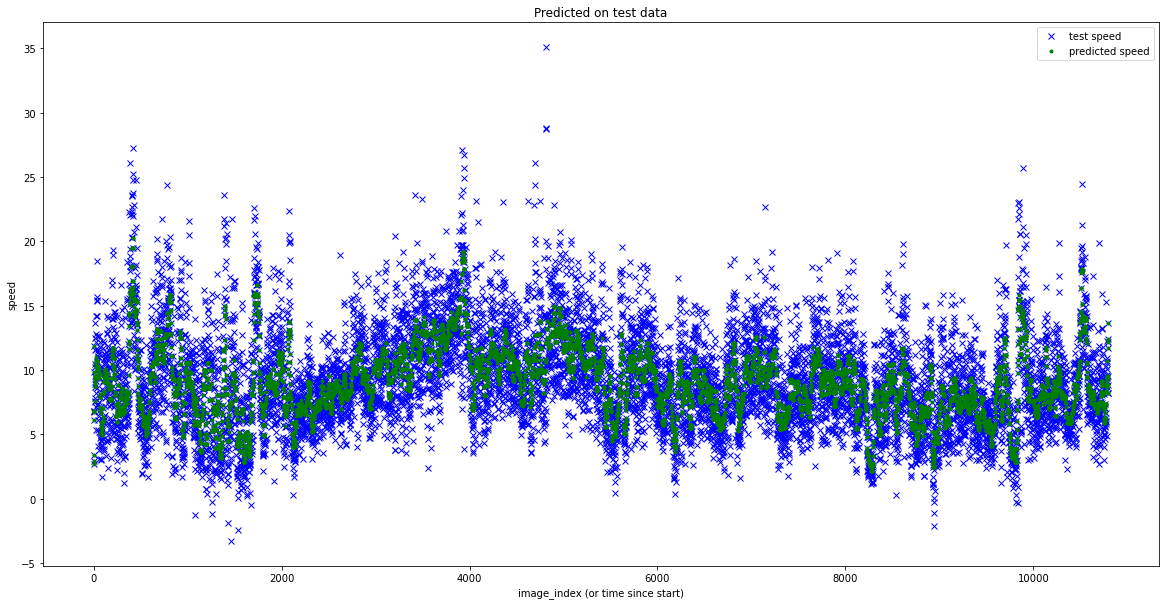

In [46]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.plot(test_meta.sort_values(['image_index'])[['image_index']], 
         test_meta.sort_values(['image_index'])[['smooth_predicted_speed']], 'g.')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['test speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

In [48]:
output_file = test_meta['smooth_predicted_speed']
output_file.to_csv(os.path.join(assets, 'test.txt'), index=False)

In [49]:
output_file.head()

0          NaN
1     6.827599
2     6.098431
3    11.884466
4     6.781638
Name: smooth_predicted_speed, dtype: float64